# Exploring some data from the Dataset

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
from src.modules.lfw_lightning_data_module import LfwImagesDataset, LFW_DataModule
from src.tools.dataset_tools import get_dataset_filename_map, dataset_download_targz

dataset_download_targz()
image_map = get_dataset_filename_map()
dataset = LfwImagesDataset(image_map)
print("Number of pictures", len(dataset))

Dataset already downloaded
Number of pictures 9164


In [3]:
#some of element in image map

c = 0
for key in image_map:
    print(key)
    print(image_map[key],"\n")
    c += 1
    if c==5:
        break

Gregory_Geoffroy
['./data/dataset/lfw-deepfunneled/Gregory_Geoffroy/Gregory_Geoffroy_0001.jpg', './data/dataset/lfw-deepfunneled/Gregory_Geoffroy/Gregory_Geoffroy_0002.jpg'] 

Rick_Carlisle
['./data/dataset/lfw-deepfunneled/Rick_Carlisle/Rick_Carlisle_0004.jpg', './data/dataset/lfw-deepfunneled/Rick_Carlisle/Rick_Carlisle_0003.jpg', './data/dataset/lfw-deepfunneled/Rick_Carlisle/Rick_Carlisle_0001.jpg', './data/dataset/lfw-deepfunneled/Rick_Carlisle/Rick_Carlisle_0002.jpg'] 

Silvia_Farina_Elia
['./data/dataset/lfw-deepfunneled/Silvia_Farina_Elia/Silvia_Farina_Elia_0001.jpg', './data/dataset/lfw-deepfunneled/Silvia_Farina_Elia/Silvia_Farina_Elia_0002.jpg', './data/dataset/lfw-deepfunneled/Silvia_Farina_Elia/Silvia_Farina_Elia_0003.jpg'] 

Slobodan_Milosevic
['./data/dataset/lfw-deepfunneled/Slobodan_Milosevic/Slobodan_Milosevic_0004.jpg', './data/dataset/lfw-deepfunneled/Slobodan_Milosevic/Slobodan_Milosevic_0001.jpg', './data/dataset/lfw-deepfunneled/Slobodan_Milosevic/Slobodan_Milose

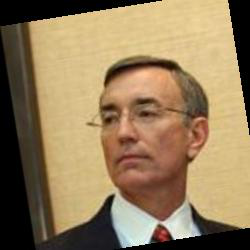

image1


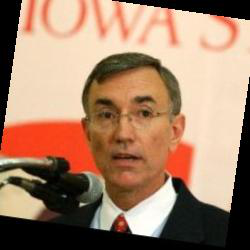

image2
They are the same person?  tensor([1.])

 
 



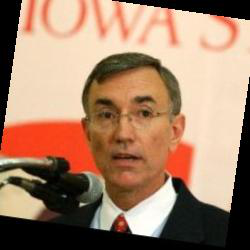

image1


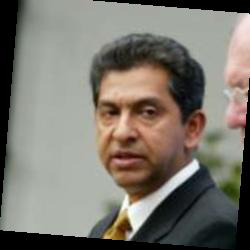

image2
They are the same person?  tensor([0.])

 
 



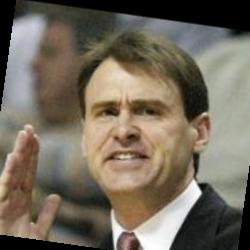

image1


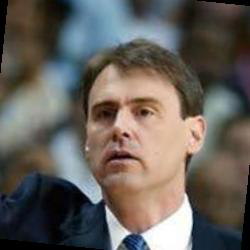

image2
They are the same person?  tensor([1.])

 
 



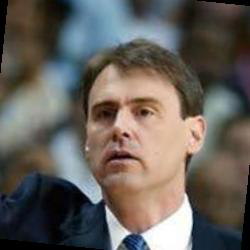

image1


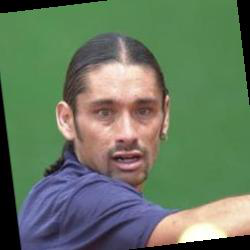

image2
They are the same person?  tensor([0.])

 
 



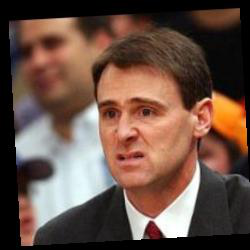

image1


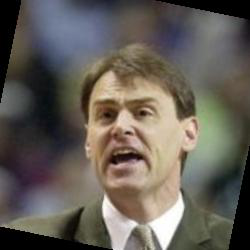

image2
They are the same person?  tensor([1.])

 
 



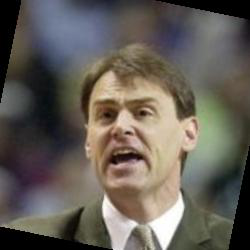

image1


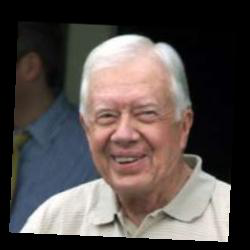

image2
They are the same person?  tensor([0.])

 
 



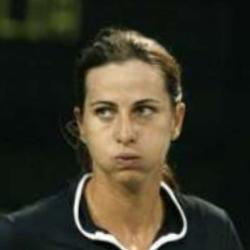

image1


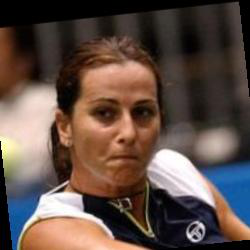

image2
They are the same person?  tensor([1.])

 
 



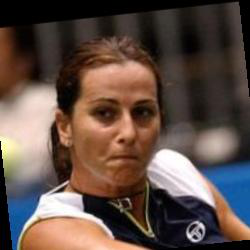

image1


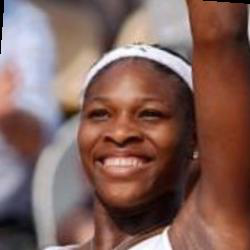

image2
They are the same person?  tensor([0.])

 
 



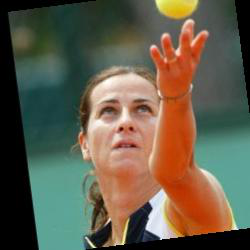

image1


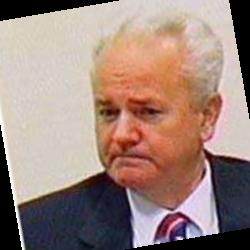

image2
They are the same person?  tensor([1.])

 
 



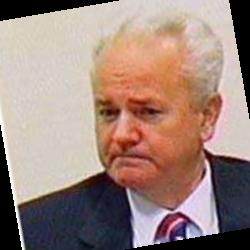

image1


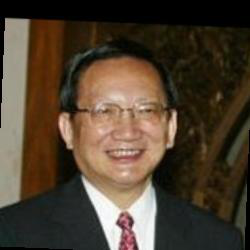

image2
They are the same person?  tensor([0.])


In [4]:
#some images

from PIL import Image
import numpy as np

c=0
for image1,image2,label in dataset:
    print("\n \n \n")
    display(image1)
    print("image1")
    display(image2)
    print("image2")
    print("They are the same person? ",label)
    c+=1
    if c==10:
        break


In [5]:
#some statistics
print("Number of subjects: ",len(image_map))
pic=0
for val in image_map.values():
    pic += len(val)
print("Total number of pictures: ",pic)
print("Avg pic for each subject: ", pic/len(image_map))

Number of subjects:  1680
Total number of pictures:  9164
Avg pic for each subject:  5.454761904761905


In [6]:
#DataLoader info
import multiprocessing as mp

dataloader = LFW_DataModule(dataset, batch_size=32, splitting_points=(0.11, 0.11), num_workers=mp.cpu_count())
dataloader.setup()
train_loader = dataloader.train_dataloader()
val_loader = dataloader.val_dataloader()
test_loader = dataloader.test_dataloader()

print("Batch_size: ", train_loader.batch_size)
print("Sampler info: ", train_loader.sampler)
print("Train loader length: ",len(train_loader))
print("Validation loader length: ",len(val_loader))
print("Test loader length: ",len(test_loader))

[7148, 1008, 1008]
Batch_size:  32
Sampler info:  <torch.utils.data.sampler.RandomSampler object at 0x7f7c1458b2d0>
Train loader length:  224
Validation loader length:  32
Test loader length:  32


max value 1.0
min value 0.0
img size torch.Size([32, 3, 128, 128])
tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.]])


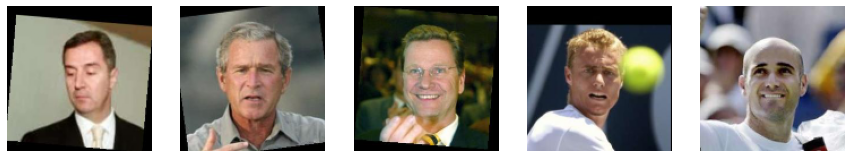

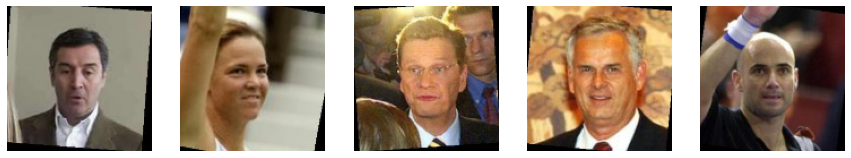

In [7]:
#Dataloader samples
from src.tools.visualization_tools import visualize_torch
import torch

for i, (im1, im2, label) in enumerate(train_loader):
    print('max value', torch.max(im1).item())
    print('min value', torch.min(im1).item())
    print('img size', im1.size())
    visualize_torch(im1[0:5])
    visualize_torch(im2[0:5])
    print(label[0:5])
    
    if i == 0:
        break

# Training the model

In [8]:
image_map = get_dataset_filename_map(max_val = -1)
dataset = LfwImagesDataset(image_map)
print("Number of pictures", len(dataset))

dataloader = LFW_DataModule(dataset, batch_size=16, splitting_points=(0.20, 0.20), num_workers=mp.cpu_count())
dataloader.setup()
train_loader = dataloader.train_dataloader()
val_loader = dataloader.val_dataloader()
test_loader = dataloader.test_dataloader()

Number of pictures 9164
[5500, 1832, 1832]


In [9]:
# %tensorboard --logdir lightning_logs

In [10]:
from src.Model.CustomModel import Siamese
import pytorch_lightning as pl

model_hparams = {
    "lr": 0.001,
    "weight_decay":1e-5,
    "filter_channels": 8,
    "filter_size": 3,
    "dropout": 0.2,
    "n_hidden1": 4096,
}

early_stop_callback = pl.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    strict=False,
    verbose=False,
    mode='min'
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath='data/checkpoint',
    filename='Siamese-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

trainer_params = {
#     "check_val_every_n_epoch": 1, 
    "callbacks": [
        early_stop_callback,
        checkpoint_callback,
    ],
    "fast_dev_run": False,
    "max_epochs": 5,
    "gpus":1 if torch.cuda.is_available() else None,
    
}

model = Siamese(hparams=model_hparams)
trainer = pl.Trainer(**trainer_params)
trainer.fit(model, dataloader)

/home/kareem/PycharmProjects/whos_that_pokemon/venv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Checkpoint directory data/checkpoint exists and is not empty. With save_top_k=3, all files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | loss_fn | BCEWithLogitsLoss | 0     
1 | conv    | CNN               | 6.1 K 
2 | linear  | FCN               | 33.6 M
3 | out     | Linear            | 4.1 K 
/home/kareem/PycharmProjects/whos_that_pokemon/venv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


1

# Save/Load Checkpoint

## Manual Save

In [11]:
import os

save_checkpoint = False
if save_checkpoint:
    save_dir = os.path.join('data', 'saved')  
    checkpoint_path = os.path.join(save_dir, 'model_saved.ckpt')
    trainer.save_checkpoint(checkpoint_path)

## Load Checkpoint

In [12]:
load_checkpoint = False

if load_checkpoint:
    checkpoint_path = checkpoint_callback.best_model_path
    chkpt_model = model.load_from_checkpoint(checkpoint_path=checkpoint_path)
    x1, x2, label, y = inference(chkpt_model, loader=dataloader.val_dataloader())
    visualize_torch(x1[:5])
    visualize_torch(x2[:5])
    print("labels", label.squeeze()[:5])
    print("predictions", y.squeeze()[:5])

## Retrain from checkpoint

In [13]:
resume_training = False
if resume_training:
    checkpoint_path = checkpoint_callback.best_model_path
    trainer = Trainer(resume_from_checkpoint=checkpoint_path)
    trainer.fit(model)

# Evaluate Model

## Run validation epoch

In [14]:
trainer.test(model, dataloader.val_dataloader())

/home/kareem/PycharmProjects/whos_that_pokemon/venv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.5179), 'test_loss': tensor(1.0359)}
--------------------------------------------------------------------------------



[{'test_loss': 1.0359102487564087, 'test_acc': 0.5179347991943359}]

labels tensor([1., 1., 1., 1., 0.])
predictions tensor([0.0481, 0.6865, 0.6503, 0.2755, 0.0144])


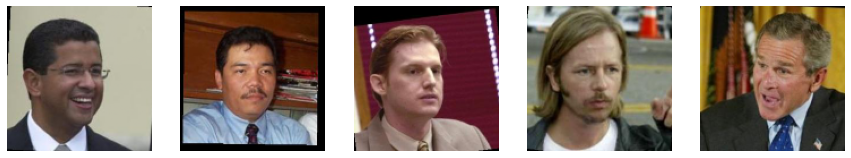

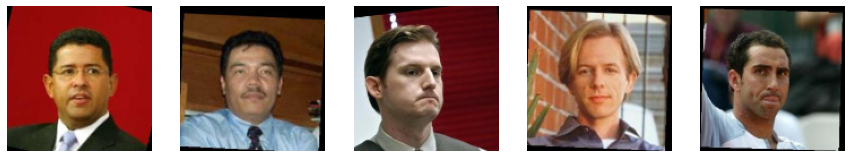

In [15]:
from src.tools.model_tools import inference

for x1, x2, label, y in inference(model, loader=dataloader.val_dataloader()):
    visualize_torch(x1[:5])
    visualize_torch(x2[:5])
    print("labels", label.squeeze()[:5])
    print("predictions", y.squeeze()[:5])
    break

## Run test epoch

In [16]:
trainer.test(model, dataloader.test_dataloader())

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.5158), 'test_loss': tensor(1.0022)}
--------------------------------------------------------------------------------



[{'test_loss': 1.0021560192108154, 'test_acc': 0.5157608985900879}]

labels tensor([0., 1., 0., 0., 1.])
predictions tensor([0.8379, 0.2271, 0.0039, 0.3222, 0.8659])


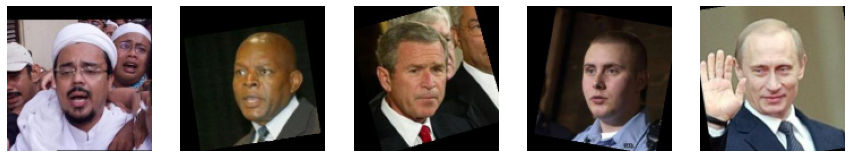

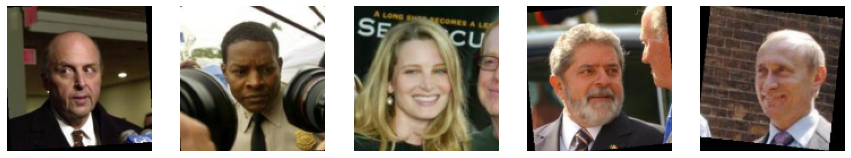

In [17]:
from src.tools.model_tools import inference

for x1, x2, label, y in inference(model, loader=dataloader.test_dataloader()):
    visualize_torch(x1[:5])
    visualize_torch(x2[:5])
    print("labels", label.squeeze()[:5])
    print("predictions", y.squeeze()[:5])
    break